In [1]:
# import modules
import numpy as np
import tensorflow as tf
import pickle
import gzip
import random
import time
import os
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import Image, display
from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


In [2]:
# return image feature dict, caption dict
def load_data(dtype):
    if dtype == 'train':
        filename = './Flickr8k_text/Flickr_8k.trainImages.txt'
    elif dtype == 'valid':
        filename = './Flickr8k_text/Flickr_8k.devImages.txt'
    elif dtype == 'test':
        filename = './Flickr8k_text/Flickr_8k.testImages.txt'
        
    image_ids = []
    features = dict()
    captions = dict()
    
    # get image ids
    with open(filename, 'r') as f:
        lines = f.read().split('\n')
        image_ids = [x.split('.')[0] for x in lines if x] # remove '.jpg'
        
    # get image features
    with gzip.open('./image_features.pkl.zip', 'rb') as f:
        all_featuers = pickle.load(f)
        features = { x: all_featuers[x][0] for x in image_ids }
        
    # get image cpations
    with open('./captions.txt', 'r') as f:
        lines = f.read().split('\n')
        for l in lines:
            tokens = l.split(' ')
            image_id = tokens[0]
            caption = ' '.join(tokens[1:])
            
            # 해당 dataset에 있는 image에 대해서 caption을 가져옴
            if image_id not in image_ids:
                continue
            
            if image_id in captions:
                captions[image_id].append(caption)
            else:
                captions[image_id] = [caption]
            
            
    return features, captions

In [3]:
train_features, train_captions = load_data('train')
# valid_features, valid_captions = load_data('valid')
test_features, test_captions = load_data('test')

print('# of images in train:', len(train_features), len(train_captions))
# print('# of images in valid:', len(valid_features))
print('# of images in test:', len(test_features), len(test_captions))

print('feature shape:', list(train_features.items())[0][1].shape)

# of images in train: 6000 6000
# of images in test: 1000 1000
feature shape: (4096,)


In [4]:
# check if wrong key(image_id) in feature dict and caption dict
key_tr_feat = set([x for x in train_features])
key_tr_capt = set([x for x in train_captions])
print(key_tr_capt - key_tr_feat)
print(key_tr_feat - key_tr_capt)

set()
set()


In [5]:
# caption에 있는 word 중 5번 이상 등장한 word만 사용하여
# word_to_idx, idx_to_word dict를 만듬
# word를 vector화 하여 input으로 주기 위함
# return word_to_idx, idx_to_word, vocab_size

def preprocess_vocab(captions):
    threshold = 20 # threshold of occurence
    count = dict()
    word_to_idx, idx_to_word = dict(), list()

    for caption_list in captions.values():
        for c in caption_list:
            tokens = c.split(' ')
            for t in tokens:
                if t in count:
                    count[t] += 1
                else:
                    count[t] = 1
            
    print('# total of words:', len(count))
    print('# of words that appears >= {}:'.format(threshold), len([w for w in count if count[w] >= threshold]))

    idx_to_word = [w for w in count if count[w] >= threshold]
    idx_to_word.append('<START>')
    idx_to_word.append('<END>')
    for i, w in enumerate(idx_to_word):
        word_to_idx[w] = i
        
    return word_to_idx, idx_to_word, len(idx_to_word)
    
    

In [6]:
# vocab_size: 우리가 사용할 총 단어의 수
# 각 caption을 index vector로 encoding할 수 있음
word_to_idx, idx_to_word, vocab_size = preprocess_vocab(train_captions)
print('vocab_size:', vocab_size)

# total of words: 7576
# of words that appears >= 20: 1065
vocab_size: 1067


In [7]:
# train set을 만듬
# ex) feature: cap1, cap2, cap3, cap4, cap5
# -> [feature, ... feature], [cap1, ... cap5]
def dict_to_list(features, captions):
    image_ids, feat, capt = [], [], []
    for image_id in features:
        _feat = features[image_id]
        _capt = captions[image_id]
        for c in _capt:
            image_ids.append(image_id)
            feat.append(_feat)
            c = '<START> ' + c + ' <END>'
            capt.append(c)
            
    return image_ids, np.array(feat), np.array(capt)

In [8]:
def display_image(image_id):
    image_filename = './Flicker8k_Dataset/' + image_id + '.jpg'
    display(Image(filename=image_filename))

len(image_ids): 30000
len(feat): 30000
len(capt): 30000


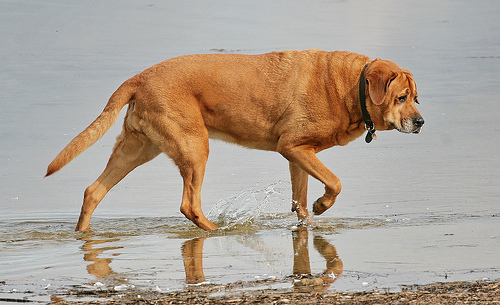

2869765795_21a398cb24 [0.        0.        0.        ... 0.        2.5150826 0.       ] <START> golden haired dog walking through shallow water <END>


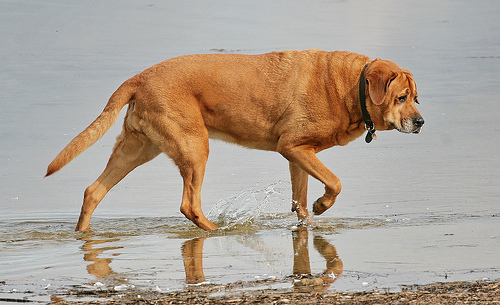

2869765795_21a398cb24 [0.        0.        0.        ... 0.        2.5150826 0.       ] <START> large dog walking through water <END>


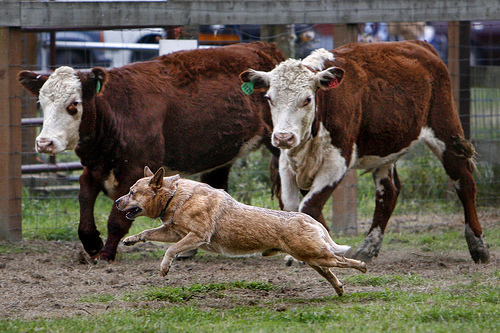

2403544744_cba152f5c1 [0. 0. 0. ... 0. 0. 0.] <START> light brown dog is playing in front of two spotted cows <END>


In [9]:
image_ids, feat, capt = dict_to_list(train_features, train_captions)
print('len(image_ids):', len(image_ids))
print('len(feat):', len(feat))
print('len(capt):', len(capt))
display_image(image_ids[0])
print(image_ids[0], feat[0], capt[0])
display_image(image_ids[1])
print(image_ids[1], feat[1], capt[1])
display_image(image_ids[6])
print(image_ids[6], feat[6], capt[6])

In [10]:
# caption generator model
class Model():
    def __init__(self, dim_img, dim_embed, dim_hidden, batch_size, maxlen, vocab_size):

        self.dim_img = dim_img
        self.dim_embed = dim_embed
        self.dim_hidden = dim_hidden
        self.batch_size = batch_size
        self.maxlen = maxlen # max seq length include (<START>, <END>)
        self.vocab_size = vocab_size
        
        # LSTM cell
        self.lstm = tf.contrib.rnn.LSTMCell(dim_hidden)

        # word embedding parameter
        self.word_embedding = tf.Variable(tf.random_uniform([self.vocab_size, self.dim_embed], -0.1, 0.1), name='word_embedding')
        self.word_embedding_bias = tf.Variable(tf.zeros([dim_embed]), name='word_embedding_bias')
        
        # image emedding parameter
        self.img_embedding = tf.Variable(tf.random_uniform([dim_img, dim_hidden], -0.1, 0.1), name='img_embedding')
        self.img_embedding_bias = tf.Variable(tf.zeros([dim_hidden]), name='img_embedding_bias')

        # lstm output -> word one-hot parameter
        self.word_encoding = tf.Variable(tf.random_uniform([dim_hidden, vocab_size], -0.1, 0.1), name='word_encoding')
        self.word_encoding_bias = tf.Variable(tf.zeros([vocab_size]), name='word_encoding_bias')


    # return placeholder and runnable components
    def build_model(self):
        img = tf.placeholder(tf.float32, [self.batch_size, self.dim_img])
        caption = tf.placeholder(tf.int32, [self.batch_size, self.maxlen])
        mask = tf.placeholder(tf.float32, [self.batch_size, self.maxlen]) # use mask when calculate XE
        
        # img feature -> img embedding(this will be first input of out LSTM)
        image_embedding = tf.matmul(img, self.img_embedding) + self.img_embedding_bias
        
        state = self.lstm.zero_state(self.batch_size, dtype=tf.float32)

        total_loss = 0.0
        for i in range(self.maxlen): 
            if i == 0:
                current_embedding = image_embedding                
            else:
                current_embedding = tf.nn.embedding_lookup(self.word_embedding, caption[:,i-1]) + self.word_embedding_bias


            out, state = self.lstm(current_embedding, state)


            if i > 0:
                labels = tf.expand_dims(caption[:, i], 1)
                ix_range=tf.range(0, self.batch_size, 1)
                ixs = tf.expand_dims(ix_range, 1)
                concat = tf.concat([ixs, labels],1)
                onehot = tf.sparse_to_dense(
                        concat, tf.stack([self.batch_size, self.vocab_size]), 1.0, 0.0)


                logit = tf.matmul(out, self.word_encoding) + self.word_encoding_bias
                xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=onehot)
                xentropy = xentropy * mask[:,i]

                loss = tf.reduce_sum(xentropy)
                total_loss += loss

        total_loss = total_loss / tf.reduce_sum(mask[:,1:])
        return total_loss, img, caption, mask
    
    # 주어진 image에 대해서 word를 generate
    def build_generator(self):
        img = tf.placeholder(tf.float32, [1, self.dim_img])
        image_embedding = tf.matmul(img, self.img_embedding) + self.img_embedding_bias
        state = self.lstm.zero_state(1, dtype=tf.float32)
        output, state = self.lstm(image_embedding, state)
 
        all_words = [] # array of tensor(not value)
        all_words.append(tf.constant(word_to_idx['<START>'])) # add <START> token

        for i in range(self.maxlen-1):
            # lstm input: embedded vector
            curr_word = tf.nn.embedding_lookup(self.word_embedding, [all_words[-1]]) + self.word_embedding_bias
            out, state = self.lstm(curr_word, state)
            logit = tf.matmul(out, self.word_encoding) + self.word_encoding_bias
            best_word = tf.squeeze(tf.argmax(logit, 1))
            all_words.append(best_word)
            

        return img, all_words

In [11]:
def train(learning_rate=0.001, continue_training=False):
    
    tf.reset_default_graph()

    _, feats, captions = dict_to_list(train_features, train_captions)
    index = (np.arange(len(feats)).astype(int))
    np.random.shuffle(index)
    maxlen = np.max([x for x in map(lambda x: len(x.split(' ')), captions)])
    model = Model(dim_img, dim_hidden, dim_embed, batch_size, maxlen, vocab_size)

    loss, image, sentence, mask = model.build_model()

    saver = tf.train.Saver(max_to_keep=5)
    global_step=tf.Variable(0, trainable=False) # learning rate decaying에 사용
    learning_rate = tf.train.exponential_decay(learning_rate, global_step,
                                       int(len(index)/batch_size), 0.95)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        if continue_training:
            saver.restore(sess,tf.train.latest_checkpoint(model_path))

        
        for epoch in range(n_epochs):
            curr_loss = 0
            loss_count = 0
            start_time = time.time()
            for start, end in zip( range(0, len(index), batch_size), range(batch_size, len(index), batch_size)):
                current_feats = feats[index[start:end]] # image feature
                current_captions = captions[index[start:end]] # caption string
                current_caption_ind = [x for x in map(lambda cap: [word_to_idx[word] for word in cap.split(' ') if word in word_to_idx], current_captions)]

                current_caption_matrix = pad_sequences(current_caption_ind, padding='post', maxlen=maxlen) # <START>, <END>를 포함한 length, 오른쪽에 padding 추
                current_mask_matrix = np.zeros((current_caption_matrix.shape[0], current_caption_matrix.shape[1]))
                nonzeros = np.array([len(x) for x in current_caption_ind])

                # fill mask matrix
                for ind, row in enumerate(current_mask_matrix):
                    row[:nonzeros[ind]] = 1

                _, loss_value = sess.run([train_op, loss], feed_dict={
                    image: current_feats.astype(np.float32),
                    sentence : current_caption_matrix.astype(np.int32),
                    mask : current_mask_matrix.astype(np.float32)
                    })

                print('Current Cost: {} \t Epoch {}/{} \t Iter {}/{}'.format(loss_value, epoch, n_epochs, start, len(feats)), end='\r')
                curr_loss += loss_value
                loss_count += 1
            end_time = time.time()
            print('Elapsed: {}, avg loss: {}, Saving the model from epoch: {}'.format(end_time-start_time, curr_loss/loss_count, epoch))
            saver.save(sess, os.path.join(model_path, 'model'), global_step=epoch)

In [12]:
### Parameters ###
dim_embed = 256
dim_hidden = 256
dim_img = 4096
batch_size = 128
n_epochs = 50
learning_rate = 0.001
model_path = './tf_checkpoint'

train(learning_rate, True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
INFO:tensorflow:Restoring parameters from ./tf_checkpoint/model-49
Elapsed: 29.839372158050537, avg loss: 5.649075628345848, Saving the model from epoch: 0
Elapsed: 26.74741244316101, avg loss: 4.078860523354294, Saving the model from epoch: 1
Elapsed: 26.827853202819824, avg loss: 3.6912605579082785, Saving the model from epoch: 2
Elapsed: 26.792245864868164, avg loss: 3.4328346863771095, Saving the model from epoch: 3
Elapsed: 26.77508783340454, avg loss: 3.242785347832574, Saving the model from epoch: 4
Elapsed: 26.83953881263733, avg loss: 3.103108120779706, Saving the model from epoch: 5
Elapsed: 26.732356309890747, avg loss: 2.990799719451839, Saving the model from epoch: 6
Elapsed: 26.89572501182556, avg loss: 2.9006525369790883, Saving the model from epoch: 7
Elapsed: 26.898864269256592, avg loss: 2.8219285062235646, Saving the model from epoch: 8
Elapsed: 26.742825269699097, avg 

In [13]:
# 주어진 image feature를 이용하여 caption 생성
def sample(image_feature):
    tf.reset_default_graph()
    maxlen = 20
    image_feature = np.expand_dims(image_feature, axis=0)
    model = Model(dim_img, dim_hidden, dim_embed, batch_size, maxlen, vocab_size)
    img, all_words = model.build_generator()
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saved_path = tf.train.latest_checkpoint(model_path)
        saver.restore(sess, saved_path)
        
        pred = sess.run(all_words, feed_dict={
            img: image_feature,
        })
    
        result = []
        for idx in pred:
            curr = idx_to_word[idx]
            result.append(curr)
            if curr == '<END>':
                break
            
        return ' '.join(result)

    
    

In [27]:
# 주어진 feature set, caption set에 대해서 
# max/min bleu score example을 보여줌
def test(features, captions):
    tf.reset_default_graph()
    maxlen = 30 # 예측할 max 길이
    model = Model(dim_img, dim_hidden, dim_embed, batch_size, maxlen, vocab_size)
    img, all_words = model.build_generator()
    saver = tf.train.Saver()
    
    max_example = [0, 0, 0] # (blue_score, image_id, pred)
    min_example = [1, 0, 0] # (blue_score, image_id, pred)
    bleu_scores = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saved_path = tf.train.latest_checkpoint(model_path)
        saver.restore(sess, saved_path)
        
        for idx, image_id in enumerate(features):
            print('{}/{}'.format(idx+1, len(features)), end='\r')
            image_feature = features[image_id]
            image_feature = np.expand_dims(image_feature, axis=0)
            y = captions[image_id]
            y = [[x.split() for x in y]] # <START>, <END> not exists
            pred = sess.run(all_words, feed_dict={
                img: image_feature,
            })
    
            result = []
            # exclude <START>, <END>
            for idx in pred[1:]:
                curr = idx_to_word[idx]
                if curr == '<END>':
                    break
                    
                result.append(curr)
                
            result = [result]
            bleu_score = corpus_bleu(y, result)
            bleu_scores.append(bleu_score)
            
            if bleu_score > max_example[0]:
                max_example[0] = bleu_score
                max_example[1] = image_id
                max_example[2] = result

            if bleu_score < min_example[0]:
                min_example[0] = bleu_score
                min_example[1] = image_id
                min_example[2] = result

    display_image(max_example[1])
    print('answer')
    for row in captions[max_example[1]]:
        print(row)

    print('pred')
    print(max_example[2])
    print('bleu:', max_example[0])
    
    
    display_image(min_example[1])
    print('answer')
    for row in captions[min_example[1]]:
        print(row)

    print('pred')
    print(min_example[2])
    print('bleu:', min_example[0])

    return bleu_scores
    

INFO:tensorflow:Restoring parameters from ./tf_checkpoint/model-49


/home/bmy4415/.conda/envs/myenv/lib/python3.5/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/bmy4415/.conda/envs/myenv/lib/python3.5/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/bmy4415/.conda/envs/myenv/lib/python3.5/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

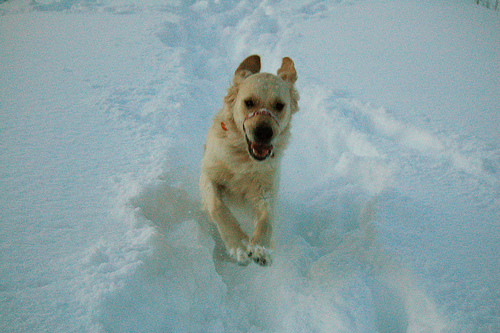

answer
dog is playing in the deep snow
dog running through deep snow pack
dog runs through the deep snow
white dog is running through the snow
white dog running through snow
pred
[['dog', 'is', 'running', 'through', 'the', 'snow']]
bleu: 1.0


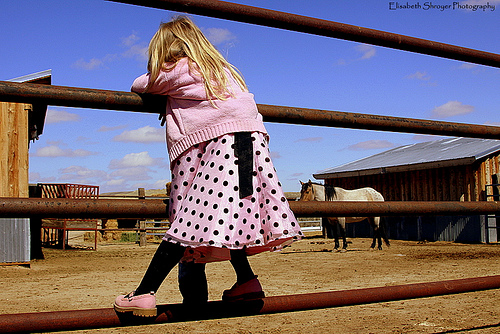

answer
girl in pink polka dots looks at horse
girl is hanging on the fence watching horse
little girl stands on the fence while peeking through it to look at the horse
young girl clings to fence ant watches the horse on the other side
young girl dressed all in pink is standing on fence and looking at horse
pred
[['boy', 'jumps', 'off', 'swing']]
bleu: 0


In [28]:
bleu_scores = test(test_features, test_captions)

In [31]:
print(len(bleu_scores))
print(sum(bleu_scores)/len(test_features))

1000
0.024524365320541083
